In [1]:
from ngsolve import *
from ngsolve.webgui import Draw
from netgen.webgui import Draw as DrawGeo
import math
import numpy as np
import sys
sys.path.append(r'..\..\bin\Release') 
from EMPY_Field import *
sys.path.append('..\include')
from MatrixSolver import MatrixSolver as solver 
sys.path.append('..\model')
from Cylinder_Yaxis_1Layer import Cylinder_Yaxis_1Layer

model=Cylinder_Yaxis_1Layer(sigma=5.e7)

mesh=model.mesh
Draw(mesh)


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

BaseWebGuiScene

In [2]:
import math
jomega=True
f=0.1
if jomega==True:
    s=2j*math.pi*f
else:
    s=2*math.pi*f
Dirichlet=False
feorder=3

symmetric_plane=model.symmetric_plane
Mu=model.Mu
Sigma=model.Sigma
reduced_region=model.reduced_region
total_region=model.total_region
conductive_region=model.conductive_region
total_boundary=model.total_boundary
reduced_boundary=model.reduced_boundary

coil=UNIF(0,1,0,2)
Av=Afield(coil)
Bv=Bfield(coil)
mu=4.e-7*math.pi
Hv=Bv/mu
As=model.ReducedField(Av, (0,0,0))
Bs=model.ReducedField(Bv, (0,0,0))

if Dirichlet==True:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane+'|'+reduced_boundary, nograds=True, complex=jomega)
else:
    fesA=HCurl(mesh, order=feorder, dirichlet=symmetric_plane, nograds=True, complex=jomega) 
A,N = fesA.TnT() 
gfA = GridFunction(fesA)
normal = specialcf.normal(mesh.dim)

a= BilinearForm(fesA)
a +=1/Mu*curl(A)*curl(N)*dx
a +=s*Sigma*A*N*dx(conductive_region)
with TaskManager():
    a.Assemble()

# Calculate Dirichlet condition terms
gfA.Set(Av, BND, mesh.Boundaries(total_boundary))
f = LinearForm(fesA)
f +=1/Mu*curl(gfA)*curl(N)*dx(reduced_region)

with TaskManager():
    f.Assemble()    
#remove components of the Dirichlet boundary
fcut = np.array(f.vec.FV())[fesA.FreeDofs()]
np.array(f.vec.FV(), copy=False)[fesA.FreeDofs()] = fcut

# Add Neumann condition terms
f += Cross(N.Trace(),Hv)*normal*ds(total_boundary)
with TaskManager():
    f.Assemble()
gfA = GridFunction(fesA)   #Clear gfA
gfA=solver.iccg_solve(fesA, gfA, a, f.vec.FV(), tol=1.e-16, max_iter=200, accel_factor=0, complex=jomega) 

fesAt=HCurl(mesh, order=feorder, definedon=total_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
fesAr=HCurl(mesh, order=feorder, definedon=reduced_region, dirichlet=symmetric_plane, nograds=True, complex=jomega)
At=GridFunction(fesAt)
Arr=GridFunction(fesAr)
Axr=GridFunction(fesAr)
At.Set(gfA,VOL, definedon=total_region)
Arr.Set(gfA,VOL, definedon=reduced_region)
Axr.Set(Av, BND, mesh.Boundaries(total_boundary))

Bt=curl(At)
Ar=Arr-Axr
Br=curl(Arr)-curl(Axr)

print("**** A field ****")
Afield=At+Ar+As
#Draw (Afield, mesh, order=3, min=-1.0, max=1.0, deformation=False)  
print("**** B field ****")
Bfield=Bt+Br+Bs

Jfield=-s*Sigma*At

mip = mesh(0,0,0)
print("center magnetic field = ", Bfield(mip))

enter iccg_solve
Dof= 35925    matrix size= 1798695.0
結果のノルム: 1.5361852571215145e-15
power=  (74234.51006276465-769.8987448021066j)
**** A field ****
**** B field ****
center magnetic field =  ((-3.739974302290506e-06+2.3431155459273613e-06j), (1.4544223972554935-0.9395128476769341j), (-3.8865727482054404e-16-6.05158737305841e-16j))


In [3]:
if jomega==False:
    WJ=Integrate(Jfield*Jfield/Sigma*dx(conductive_region, mesh))
else:
    WJ=Integrate((Jfield.real*Jfield.real+Jfield.imag*Jfield.imag)/Sigma*dx(conductive_region), mesh) /2
print(" Average Joule loss= ", WJ)

 Average Joule loss=  241.87082405508121


In [4]:
if jomega==False:
    with TaskManager():Draw (Bfield, mesh, order=3, min=0., max=1.2, deformation=False) 
else:
    print("**** B field real****")
    with TaskManager():Draw (Bfield.real, mesh, order=3, min=0., max=1.2, deformation=False) 
    print("**** B field imag****")
    with TaskManager():Draw (Bfield.imag, mesh, order=3, min=0., max=1.2, deformation=False) 

if jomega==False:
    print("**** J field ****")
    with TaskManager():Draw (Jfield, mesh, order=3, deformation=False) 
else:
    print("**** J field real ****")
    with TaskManager():Draw (Jfield.real, mesh, order=3, deformation=False) 
    print("**** J field imag ****")
    with TaskManager():Draw (Jfield.imag, mesh, order=3, deformation=False) 

**** B field real****


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

**** B field imag****


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

**** J field real ****


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

**** J field imag ****


WebGuiWidget(layout=Layout(height='50vh', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.24…

Dirichlet=False

B real [-1.2,1.2]
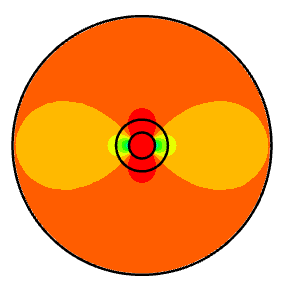
B imag [-1.2,1.2]
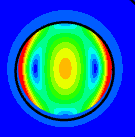

center magnetic field =  ((-3.739974302290506e-06+2.3431155459273613e-06j), (1.4544223972554935-0.9395128476769341j), (-3.8865727482054404e-16-6.05158737305841e-16j))

Jz real [-1e6, 1e6]
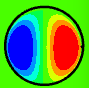
Jz imag [-5e6, 5e6]
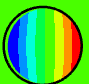

Average Joule loss=  241.87082405508121